In [30]:
import os, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import hvplot.pandas
# from bokeh.io import curdoc
import datetime
from pull_garmin_data import pull_workout_data_from_date
from main import Scraper, find_existing_date
import datetime
import pandas as pd
from garmin_analysis import calc_load, filter_df, weekly_bins
# curdoc().theme = "dark_minimal"

In [2]:
grade_conversion = {
    "6B+": 4,
    "6C" : 5,
    "6C+": 5.5,
    "7A" : 6,
    "7A+": 7,
    "7B" : 8,
    "7B+": 8.5
}

In [3]:
GARMIN_STRENGTH_LOG = "./data/garmin_log.csv"
MB_LOG = "./data/mb_log.csv"
BLOCK_START = "2023-11-20"

# Log summary reporting


In [4]:
df = pd.read_csv(GARMIN_STRENGTH_LOG)

df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")


In [5]:
# Perform some filtering and convert TUT to reps
# and add a week col
idx, labels, cut_series = weekly_bins(BLOCK_START, dataframe=df)
df['dt_cut'] = cut_series
df['week'] = df.dt_cut.apply(lambda x: labels[x-1])

df = calc_load(filter_df(df, min_kg=0))
df

2024-01-10 11:27:00,956: INFO [garmin_analysis.py:105]: 8 weeks: 
                 0
0  Week 1 (20 Nov)
1  Week 2 (27 Nov)
2  Week 3 (04 Dec)
3  Week 4 (11 Dec)
4  Week 5 (18 Dec)
5  Week 6 (25 Dec)
6  Week 7 (01 Jan)
7  Week 8 (08 Jan)


,date,ename,ereps,kg,duration,dt_cut,week,rep_load
0,2024-01-08,no hangs,1,62.0,10.0,8,Week 8 (08 Jan),62.0
1,2024-01-08,no hangs,1,62.0,10.0,8,Week 8 (08 Jan),62.0
2,2024-01-08,no hangs,2,62.0,10.0,8,Week 8 (08 Jan),124.0
3,2024-01-08,no hangs,1,62.0,10.0,8,Week 8 (08 Jan),62.0
4,2024-01-08,no hangs,1,62.0,10.0,8,Week 8 (08 Jan),62.0
...,...,...,...,...,...,...,...,...
299,2023-11-21,deadlift,3,130.0,30.0,1,Week 1 (20 Nov),390.0
300,2023-11-21,HB: IMR 20mm,10,82.5,30.0,1,Week 1 (20 Nov),990.0
301,2023-11-21,deadlift,2,130.0,30.0,1,Week 1 (20 Nov),260.0
302,2023-11-21,HB: IMR 20mm,10,82.5,30.0,1,Week 1 (20 Nov),990.0


In [6]:
# Report block summary
def find_start_end_kg(group):
    

block_group = df.groupby('ename', as_index=False).aggregate(
    tot_sessions = ("date", "nunique")
)
block_group

,ename,tot_sessions
0,HB: IMR 20mm,11
1,HB: SC 20mm,10
2,benchpress,7
3,deadlift,9
4,no hangs,17
5,weighted pull up,6


In [18]:
grp = df.groupby(['ename', 'dt_cut']).aggregate(
    volume_reps = ('ereps', 'sum'),
    volume_time = ('duration', 'sum'),
    max_kg = ('kg', 'max'),
    accum_load = ('rep_load', 'sum'),
    sessions = ('date', 'nunique')    
).fillna(0)
grp

/tmp/ipykernel_1213566/4192543423.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(['ename', 'dt_cut']).aggregate(


volume_reps  volume_time  max_kg  accum_load  \
ename            dt_cut                                                 
HB: IMR 20mm     1                70      210.000    86.0     7056.00   
                 2                60      264.600    87.5     9096.24   
                 3                33      120.000    88.0     4172.00   
                 4                 7       70.000    87.0     2436.00   
                 5                 3       30.000    86.0     1032.00   
                 6                 3       30.000    86.0     1032.00   
                 7                 3       30.000    88.0     1044.00   
                 8                 0        0.000     0.0        0.00   
HB: SC 20mm      1                55      180.000   102.5     7290.00   
                 2                65      230.000   105.0     9505.00   
                 3                33      120.000   105.0     4874.00   
                 4                 7       70.000   106.0     2932.00   
                 5                 3       30.000   103.0     1236.00   
                 6                 3       30.000   106.0     1272.00   
                 7                 3       30.000   103.0     1236.00   
                 8                 0        0.000     0.0        0.00   
benchpress       1                25      240.000    60.0     1500.00   
                 2                47      300.000    60.0     2590.00   
                 3                28      270.000    65.0     1640.00   
                 4                15       90.000    60.0      900.00   
                 5                 0        0.000     0.0        0.00   
                 6                15       90.000    65.0      975.00   
                 7                11       85.551    65.0      715.00   
                 8                 0        0.000     0.0        0.00   
deadlift         1                21      240.000   135.0     2765.00   
                 2                49      411.400   130.0     5924.00   
                 3                 0        0.000     0.0        0.00   
                 4                20      186.747   135.0     2650.00   
                 5                12       85.359   135.0     1620.00   
                 6                 0        0.000     0.0        0.00   
                 7                16       89.842   135.0     2160.00   
                 8                 0        0.000     0.0        0.00   
no hangs         1                 0        0.000     0.0        0.00   
                 2                16      160.000    62.0      992.00   
                 3                23      200.000    62.0     1426.00   
                 4                24      240.000    62.0     1488.00   
                 5                33      320.000    62.0     2046.00   
                 6                16      160.000    62.0      992.00   
                 7                11      110.000    62.0      682.00   
                 8                 9       80.000    62.0      558.00   
weighted pull up 1                15      150.000   106.5     1597.50   
                 2                10       83.756   107.0     1070.00   
                 3                 0        0.000     0.0        0.00   
                 4                15      143.327   111.0     1617.00   
                 5                 0        0.000     0.0        0.00   
                 6                15       90.000   106.0     1554.00   
                 7                 9       74.517   103.0      927.00   
                 8                 0        0.000     0.0        0.00   

                         sessions  
ename            dt_cut            
HB: IMR 20mm     1              2  
                 2              2  
                 3              1  
                 4              3  
                 5              1  
                 6              1  
                 7              1  
                 8              0  
HB: SC 20mm   

# MB log summary reporting

In [28]:
df = pd.read_csv("./data/mb_log.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       471 non-null    object 
 1   name       471 non-null    object 
 2   grade      471 non-null    object 
 3   setter     471 non-null    object 
 4   mygrade    471 non-null    object 
 5   attempts   471 non-null    int64  
 6   ticked     471 non-null    bool   
 7   comment    6 non-null      object 
 8   grade_v    471 non-null    float64
 9   mygrade_v  471 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 33.7+ KB


In [20]:
df[df.date == datetime.datetime.strptime("2023-09-28", "%Y-%m-%d")]

,date,name,grade,setter,mygrade,attempts,ticked,comment,grade_v,mygrade_v
134,2023-09-28,WUTHERING HEIGHTS,6B+,Ben Moon,6B+,1,True,NaN,4.0,4.0
135,2023-09-28,STANDARD AND POOR'S,6B+,Vincent Minecci,6B+,2,True,NaN,4.0,4.0
136,2023-09-28,I'M NOT A SETTER,6B+,Emilee Sudweeks,6B+,2,False,NaN,4.0,4.0
137,2023-09-28,RISCALDAMENTO TIA 6A,6B+,Federico Camboni,6B+,2,True,NaN,4.0,4.0
138,2023-09-28,TBA WARMUP 1,6B+,Luis Rodriguez,6B+,1,False,NaN,4.0,4.0
139,2023-09-28,FORSØK 25,6B+,atoneni,6B+,2,False,NaN,4.0,4.0
315,2023-09-28,YOURS,6C,Felicity Holt,6C,1,False,NaN,5.0,5.0
316,2023-09-28,PE3/1,6C,Nick Churchill,6C,3,True,NaN,5.0,5.0
317,2023-09-28,SOURKRAWT,6C,Kyle Knapp,6C,1,False,NaN,5.0,5.0
318,2023-09-28,7A TOO MUCH,6C+,CH Kuo,6C+,4,True,NaN,5.5,5.5


In [3]:
# Group by problem and report number of tries, if it is ticked or not, number of days, setter
from collections import namedtuple

def _groupby(raw_df, problem_sequence_df=None):
    
    def count_days(dt_series):
        return len(set(dt_series))
    
    df = raw_df[:]

    df.loc[:, "date"] = pd.to_datetime(df.date, format="%Y-%m-%d").dt.date

    df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
        total_attempts = ("attempts", np.sum),
        total_days = ("date", count_days),
        ticked = ("ticked", np.any),
        last_tried = ("date", max),
        first_tried = ("date", min)
    )

    # TODO: Not sure how to do aggregating functions on groupby using multiple columns
    # e.g. passing in both 'date' and 'ticked' as inputs. until then.. using a loop and merge

    detailed_stats = []

    DateStats = namedtuple(
        "DateStats", 
        "name \
            first_ticked \
                attempts_to_send \
                    days_to_send \
                        num_repeats"
    )

    for n in df.name:
        first_ticked = np.nan
        tdf = raw_df[raw_df.name == n]
        ticked_sessions = tdf[tdf.ticked]
        
        try:
            first_ticked = ticked_sessions.date.min()
            attempts_to_send = tdf.loc[tdf.date<=first_ticked, "attempts"].sum()
            days_to_send = tdf.loc[tdf.date<=first_ticked].__len__()
        
        except Exception as e:
            print(e)
            first_ticked = np.nan
            attempts_to_send = np.nan
            days_to_send = np.nan

        num_repeats = ticked_sessions.__len__()
        
        detailed_stats.append(
            DateStats(n, first_ticked, attempts_to_send, days_to_send, num_repeats)
        )

    detailed_stats_df = pd.DataFrame(detailed_stats, columns=DateStats._fields)

    merged = pd.merge(left=df, right=detailed_stats_df, how='left', on='name')

    if problem_sequence_df is not None:
        merged = pd.merge(left=df, right=problem_sequence_df, how='left', on='name')

    return merged


def current_projects_ranked(raw_df, as_table=True):
    df = _groupby(raw_df)
    df = df[~df.ticked].sort_values(
        ["total_days", "total_attempts"], 
        ascending=False
    )
    df = df.drop(columns=['num_repeats', 'attempts_to_send', 'days_to_send', 'first_ticked', 'ticked'])
    
    df['last_tried_days'] = (datetime.date.today() - df.last_tried)
    df['span_days'] = (df.last_tried - df.first_tried)

    if as_table:
        return df.hvplot.table(sortable=True, selectable=True)

    return df

def ticked_climbs_ranked(
        raw_df,
        topk=10, 
        by=["attempts_to_send", "num_repeats"], 
        ascending=[False, True]
        ):
    # By default returns top ticked climbs ranked by most attempts needed, then by least repeats
    # good for choosing as repeats
    df = _groupby(raw_df)
    return df[df.ticked].sort_values(by=by, ascending=ascending).drop(columns='ticked')[:10]

# def ticked_climbs_ranked(raw_df, topk=10, by='attempts'):
    
#     # Get top-k list of climbs by difficulty
#     topk_climbs = raw_df.groupby(["name"], as_index=False).aggregate(
#         difficulty = ("grade_v", np.max)
#     ).loc[:topk, "name"]

#     topk_climbs = set(topk_climbs.tolist())
#     return topk_climbs

#     return df
    # return df[df.ticked].hvplot.table(sortable=True, selectable=True)



# df2[~df2.ticked].groupby("setter")




In [4]:
problem_sequences = pd.read_csv("hold_sequences.csv")
# names have a .
problem_sequences.loc[:, 'name'] = problem_sequences.name.apply(lambda x: x[:-1])
grp = _groupby(df, problem_sequence_df=problem_sequences)

FileNotFoundError: [Errno 2] No such file or directory: 'hold_sequences.csv'

In [143]:
grp

,name,grade_v,setter,total_attempts,total_days,ticked,last_tried,first_tried,sequence
0,#2 KH,5.5,Kyle Hilton,3,2,True,2022-10-06,2022-09-01,NaN
1,(*)(*)FAKE,4.0,Mystery Frog Man,1,1,True,2023-05-30,2023-05-30,"['F5', 'E8', 'H11', 'F15', 'D18']"
2,1,4.0,Hugo Hoyer,1,1,True,2023-11-26,2023-11-26,"['I5', 'F5', 'J8', 'G8', 'I10', 'K11', 'J13', ..."
3,1817,5.0,Randall Baum,3,1,False,2023-06-13,2023-06-13,"['K5', 'H5', 'F7', 'J10', 'E11', 'E13', 'B16',..."
4,1K,4.0,Bryant Noble,1,1,True,2023-11-28,2023-11-28,"['F5', 'G9', 'E10', 'G13', 'E15', 'D17', 'B18']"
...,...,...,...,...,...,...,...,...,...
232,¡APUNT****!,4.0,AJ Rimes,1,1,True,2023-12-12,2023-12-12,"['G2', 'B3', 'F5', 'E8', 'G9', 'E10', 'G13', '..."
233,紙一重 -KAMI HITOE-,5.5,seishirou shirai,6,1,True,2022-09-01,2022-09-01,NaN
234,課題2,5.5,atsushi takizawa,3,1,True,2023-02-16,2023-02-16,"['F5', 'E8', 'C10', 'G14', 'F15', 'I18']"
235,課題24,4.0,atsushi takizawa,1,1,True,2023-01-24,2023-01-24,"['F5', 'J8', 'B9', 'I10', 'E13', 'F14', 'B16',..."


In [147]:
df.name.str.replace(" ", "_")

0              POPIFRESCO
1           THE_SENDTRAIN
2                  BORNEO
3               BUTOLOGIA
4      FINGER_LICKIN_EASY
              ...        
486       AN_EASY_PROBLEM
487     WUTHERING_HEIGHTS
488                BITTER
489          KLINGON_EASY
490          FLASH_GORDON
Name: name, Length: 491, dtype: object

In [154]:
proj = current_projects_ranked(df, as_table=False)
# make name match sequences
proj.loc[:, "name"] = proj.name.str.replace(" ", "_")

proj = pd.merge(proj, problem_sequences, on='name', how='left')

In [ ]:
import ast
proj.loc[:, "sequence"] = proj.sequence.apply(ast.literal_eval)

In [167]:
proj = proj.dropna(subset='sequence')

from collections import Counter
from itertools import chain

counter_obj = Counter(chain.from_iterable(proj.sequence))

In [168]:
counter_obj.most_common()

[('D18', 13),
 ('E8', 10),
 ('H16', 9),
 ('J5', 8),
 ('K5', 6),
 ('E12', 6),
 ('G4', 6),
 ('H11', 5),
 ('F5', 5),
 ('F11', 5),
 ('I18', 5),
 ('H5', 5),
 ('F14', 4),
 ('G17', 4),
 ('E16', 4),
 ('H9', 4),
 ('I12', 4),
 ('A5', 4),
 ('E13', 4),
 ('J8', 4),
 ('G15', 4),
 ('K18', 4),
 ('K9', 3),
 ('I14', 3),
 ('I5', 3),
 ('H14', 3),
 ('E18', 3),
 ('G18', 3),
 ('C13', 3),
 ('A18', 3),
 ('G9', 3),
 ('H12', 3),
 ('E15', 3),
 ('K7', 2),
 ('C7', 2),
 ('E7', 2),
 ('A9', 2),
 ('E6', 2),
 ('B10', 2),
 ('F9', 2),
 ('D10', 2),
 ('F12', 2),
 ('G8', 2),
 ('B16', 2),
 ('G14', 2),
 ('J13', 2),
 ('H10', 2),
 ('K8', 2),
 ('K14', 2),
 ('I10', 2),
 ('D15', 2),
 ('C10', 2),
 ('K12', 1),
 ('D13', 1),
 ('A14', 1),
 ('B3', 1),
 ('C14', 1),
 ('C18', 1),
 ('D9', 1),
 ('K11', 1),
 ('J16', 1),
 ('K6', 1),
 ('F15', 1),
 ('F10', 1),
 ('J7', 1),
 ('I4', 1),
 ('B13', 1),
 ('D16', 1),
 ('F7', 1),
 ('J10', 1),
 ('E11', 1),
 ('C12', 1),
 ('D5', 1),
 ('B8', 1),
 ('E10', 1),
 ('E14', 1),
 ('F13', 1),
 ('G13', 1),
 ('I15', 1),

In [233]:
from image_to_vector import find_edges, BoardCoor
from typing import List
import skimage
import cv2

def make_heatmap_of_holds(problems: List[np.ndarray], blank: np.ndarray) -> np.ndarray:
    def minmax(img):
        return (((img-np.min(img)) / (img.max() - img.min())) * 255).astype(np.uint8)
    
    # TODO: Hardcoded based on the blank board screenshot. May need to adjust x,y
    board_background_colour = np.linalg.norm(blank, axis=2)[700,40]
    bc = find_edges(blank, board_background_colour)
    # _logger.info(f'{bc}, {board_background_colour}')
    blank = blank[bc.ymin:bc.ymax, bc.xmin:bc.xmax]
    
    matched_binaries = []

    for img in problems:
        bc_img = find_edges(img, board_background_colour)
        img_board = img[bc_img.ymin:bc_img.ymax, bc_img.xmin:bc_img.xmax]
        # resize to match blank - Crop to hardcoded evenly spaced bolt sizes
        img_board = skimage.transform.resize(img_board, blank.shape)
        # Find differences (circles..)
        matched = np.logical_and(img_board, blank).astype(float)
        m = matched.sum(axis=(-1)) == 4
        m = skimage.morphology.area_closing(m, area_threshold=100)
        
        
        matched_binaries.append((~m).astype(int))

    stacked_gray = minmax(np.sum(np.dstack(matched_binaries), axis=-1))
    blank_gray = skimage.color.rgb2gray(blank[..., :3])
    # blank_gray = np.dstack(blank_gray)


    stacked_heatmap = cv2.applyColorMap(stacked_gray, cv2.COLORMAP_JET)
    plt.imshow(blank_gray, cmap='gray')
    plt.imshow(stacked_heatmap, cmap='jet', alpha=0.5)
    return stacked_heatmap
    print(stacked_heatmap.shape, blank.shape)

    stacked_heatmap = cv2.addWeighted(stacked_heatmap, 0.5, (blank[..., :3]*255).astype(np.uint8), 0.5, 0)
    # stacked_rgba = np.dstack([
    #     np.ones_like(stacked_gray),
    #     np.zeros_like(stacked_gray),
    #     np.zeros_like(stacked_gray),
    #     stacked_gray
    # ])

    return stacked_heatmap            

    
    
    
    return matched_binaries

imgs = []
for i, fp in enumerate(os.listdir("images")):
    fpp = os.path.join("images", fp)
    imgs.append(plt.imread(fpp))
    if i==10:
        break
base = plt.imread("blank_MB.png")



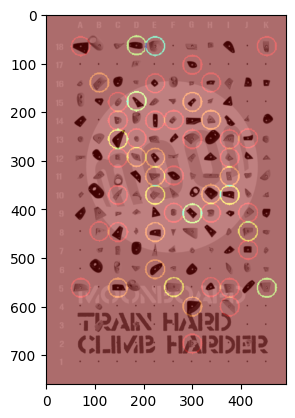

In [234]:
matched = make_heatmap_of_holds(imgs, base)

In [206]:

np.unique(minmax(matched))

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 1.        ])

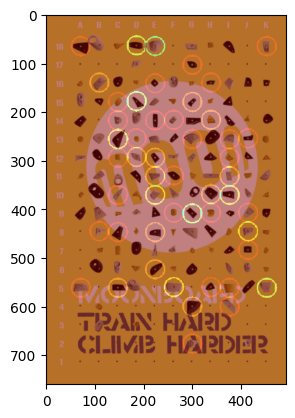

In [228]:
plt.imshow(matched)

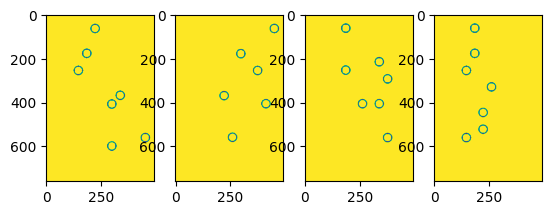

In [195]:
fig, ax = plt.subplots(ncols=4)
for i in range(4):
    ax[i].imshow(matched[i])

In [197]:
m = matched[0]
np.unique(m)
m[0,0]

True

In [26]:
print(ticked_climbs_ranked(df[df.grade_v == 5.5], by=["attempts_to_send"], ascending=[True])["name"].to_string(index=False))

           LEAN BACK
               #2 KH
               COBIA
     CHILLIN WITH TJ
     RIGHTNESS, PT.3
                 課題2
         7A TOO MUCH
I LOVE ROCK AND ROLL
 ATTREZZO DI TORTURA
   GESIER-RIGHT HAND


/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <function sum at 0x7fda7c13bb80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  df = raw_df.groupby(["name","grade_v", "setter"]

In [6]:
proj = current_projects_ranked(df)

/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <function sum at 0x7fda7c13bb80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  df = raw_df.groupby(["name","grade_v", "setter"]

In [7]:
proj

:Table   [name,grade_v,setter,total_attempts,total_days,last_tried,first_tried,last_tried_days,span_days]

In [8]:
ticked = ticked_climbs_ranked(df)

/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <function sum at 0x7fda7c13bb80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
/tmp/ipykernel_1240593/3283943861.py:13: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  df = raw_df.groupby(["name","grade_v", "setter"]

In [9]:
ticked

,name,grade_v,setter,total_attempts,total_days,last_tried,first_tried,first_ticked,attempts_to_send,days_to_send,num_repeats
23,ASTRO CREEP,4.0,Jonny Summers,43,5,2023-12-12,2023-05-18,2023-11-21,40,5,1
145,NORTHSIDE,6.0,Matt Mcnair,13,4,2023-11-30,2023-07-18,2023-11-30,13,4,1
182,SHAKEDOWN STREET,5.5,Matt Poiesz,13,3,2023-05-07,2023-04-18,2023-05-07,13,4,1
140,MOON CASTLE,5.0,Ben Moon,12,5,2023-12-02,2023-02-21,2023-12-02,12,5,1
222,VIVA,4.0,Hakan Ertekin,12,2,2023-10-17,2023-09-26,2023-10-17,12,4,1
152,OVN,5.0,Jørgen Bryn Henriksen,10,5,2023-05-07,2023-03-02,2023-05-07,10,5,1
184,SISÚ,5.0,edu moya,10,3,2023-12-24,2023-12-05,2023-12-24,10,4,1
202,TESS,5.5,Ben Moon,9,3,2023-04-04,2023-02-16,2023-04-04,9,4,1
115,IMPROVVISAZIONE,6.0,Jean-Pierre Bovo,8,2,2023-07-18,2023-05-09,2023-07-18,8,2,1
136,MAGNUM,6.0,Lukasz Zielonka,8,3,2023-04-04,2023-03-15,2023-04-04,8,3,1


In [137]:
# Havce a look at the hold sequences generated by CV hacky script

hs = pd.read_csv("hold_sequences.csv")
hs.head()
hs.loc[:, 'name'] = hs.name.apply(lambda x: x[:-1])

In [138]:
pd.merge(left=df, right=hs, on='name')

,date,name,grade,setter,mygrade,attempts,ticked,comment,grade_v,mygrade_v,sequence
0,2023-12-14,POPIFRESCO,6B+,JAVIERMENG,6B+,2,False,NaN,4.0,4.0,"['G2', 'E6', 'G9', 'C10', 'C13', 'D15', 'D18']"
1,2023-05-07,POPIFRESCO,6B+,JAVIERMENG,6B+,2,True,NaN,4.0,4.0,"['G2', 'E6', 'G9', 'C10', 'C13', 'D15', 'D18']"
2,2023-12-14,BORNEO,7A,Stuart Ivory,6C+,1,True,NaN,6.0,5.5,"['G2', 'E6', 'G9', 'I10', 'J13', 'G15', 'G17',..."
3,2023-12-12,BORNEO,7A,Stuart Ivory,6C+,6,True,NaN,6.0,5.5,"['G2', 'E6', 'G9', 'I10', 'J13', 'G15', 'G17',..."
4,2023-12-14,BUTOLOGIA,6C,nicholas farenzena,6C,1,True,NaN,5.0,5.0,"['F5', 'J9', 'E10', 'I13', 'G15', 'K18']"
...,...,...,...,...,...,...,...,...,...,...,...
143,2022-09-29,DSTYLE,6B+,hamad_climbs,6B+,1,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
144,2022-09-18,DSTYLE,6B+,hamad_climbs,6B+,2,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
145,2022-09-08,DSTYLE,6B+,hamad_climbs,6B+,1,False,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
146,2022-08-30,DSTYLE,6B+,hamad_climbs,6B+,1,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"


In [153]:
for n in problem_sequences.name:
    if "WREK" in n:
        print(n)

In [238]:
current_projects_ranked(df, as_table=False).to_csv("current_projects.csv")
ticked_climbs_ranked(df).to_csv("ticked_by_hardest.csv")

# Strength scripting EDA
- Scrape garmin and MB data from latest date (find from csv locations)
- Prompt for a 'last n weeks' parameter (e.g. 8 weeks back)
- Generate mb tables
    - Current projects
    -  

In [29]:
from pull_garmin_data import pull_workout_data_from_date
from main import Scraper, find_existing_date
import datetime
import pandas as pd


In [47]:
GARMIN_STRENGTH_LOG = "./data/garmin_log.csv"
MB_LOG = "./data/mb_log.csv"

In [48]:
# existing_strength_df, last_date = find_existing_date(GARMIN_STRENGTH_LOG)
# from_date = (last_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
# garmin_df = pull_workout_data_from_date(as_dataframe=True, n_most_recent_activities=9999)
garmin_df = pd.read_csv(GARMIN_STRENGTH_LOG)
garmin_df["date"] = pd.to_datetime(garmin_df.date, format="%Y-%m-%d")
garmin_df.head()
strength_df = garmin_df
# garmin_df.to_csv(GARMIN_STRENGTH_LOG)


In [49]:
set(garmin_df.ename.to_list())

{'HB: IMR 20mm', 'HB: SC 20mm', 'benchpress', 'deadlift', 'weighted pull up'}

In [50]:
# Lets add in the reflex logs
rdf = (pd.read_csv("./data/reflex_exercise_log_full.csv").drop(columns="Unnamed: 0")
       .rename(columns={"reps":"ereps"}))
rdf["date"] = pd.to_datetime(rdf.date, format="%d-%m-%y")
rdf["duration"] = 30
rdf.loc[rdf.ename=='weighted pull-up', 'ename'] = 'weighted pull up'
rdf.head()


,date,ename,enum,ereps,kg,rpe,duration
0,2023-10-04,deadlift,0,5,70.0,8,30
1,2023-10-04,deadlift,1,3,130.0,9,30
2,2023-09-18,benchpress,0,6,60.0,8,30
3,2023-09-18,benchpress,0,6,60.0,8,30
4,2023-09-18,benchpress,0,6,60.0,8,30


In [51]:
strength_df = pd.concat([rdf[["date", "ename", "ereps", "kg", "duration"]], garmin_df])
strength_df.sort_values(by='date', ascending=False, inplace=True)
strength_df.reset_index(drop=True, inplace=True)

In [52]:
# Save the combined CSV (Initial table build up)
strength_df.to_csv(GARMIN_STRENGTH_LOG, index=False)

## Table of exercises by week reporting frequency etc..

- Takes as input the date of the first week of the block (or as far back as wanted)
- Reports on weeks until present day


In [42]:
BLOCK_START = "2024-01-16"  # This is week 1 of block, weeks start on tuesdays (first big day)
start_dt = datetime.datetime.strptime(BLOCK_START, "%Y-%m-%d")
end_dt = datetime.date.today()
end_dt += datetime.timedelta(days=(8-datetime.date.today().weekday())) # Round to tuesday
bins_dt = pd.date_range(start=start_dt, end=end_dt, freq="7D")
bin_labels = [f"Week {i+1} ({dt.strftime('%d %b')})" for i,dt in enumerate(bins_dt[:-1])]
bins_dt, bin_labels

(DatetimeIndex(['2024-01-16', '2024-01-23', '2024-01-30', '2024-02-06',
                '2024-02-13'],
               dtype='datetime64[ns]', freq='7D'),
 ['Week 1 (16 Jan)', 'Week 2 (23 Jan)', 'Week 3 (30 Jan)', 'Week 4 (06 Feb)'])

In [43]:
strength_df['dt_cut'] = pd.cut(strength_df['date'],
                               bins=bins_dt,
                               labels=bin_labels,
                               right=False,
                               include_lowest=True)
def calc_load(df, tut_to_rep_mapping={'HB: SC 20mm': 2.5, 'HB: IMR 20mm': 2.5}):
    df.loc[:, 'rep_load'] = df.ereps * df.kg
    tut_only = df.ename.isin(tut_to_rep_mapping.keys())
    df.loc[tut_only, "rep_load"] = df.loc[tut_only].apply(
        lambda row: (row.duration / tut_to_rep_mapping[row.ename]) * row.kg,
        axis=1
    )
    return df

# Filter out by name, kg, etc. To filter out 'no hangs'
def filter_df(
        df: pd.DataFrame, 
        exclude_names=[], 
        min_kg=0, 
        max_duration=30,
        rename_nohangs=True
        ):
    df.loc[df.duration > max_duration, "duration"] = 30
    if rename_nohangs:
        df.loc[((df.ename == "HB: IMR 20mm") | (df.ename == "HB: SC 20mm")) 
               & (df.kg == 62), "ename"] = "no hangs"
        
    return df[(~df.ename.isin(exclude_names)) & (df.kg>min_kg)]

df2 = filter_df(strength_df, min_kg=0)
df2 = calc_load(df2)
df2

,date,ename,ereps,duration,kg,dt_cut,rep_load
0,2024-02-04,weighted pull up,5,18.105,94.0,Week 3 (30 Jan),470.0
1,2024-02-04,benchpress,5,30.000,60.0,Week 3 (30 Jan),300.0
2,2024-02-04,weighted pull up,5,2.352,94.0,Week 3 (30 Jan),470.0
3,2024-02-04,benchpress,5,28.452,60.0,Week 3 (30 Jan),300.0
4,2024-02-04,weighted pull up,5,24.426,94.0,Week 3 (30 Jan),470.0
...,...,...,...,...,...,...,...
479,2023-09-20,benchpress,6,30.000,60.0,NaN,360.0
480,2023-09-20,benchpress,6,30.000,60.0,NaN,360.0
481,2023-09-18,benchpress,6,30.000,60.0,NaN,360.0
482,2023-09-18,benchpress,6,30.000,60.0,NaN,360.0


<Axes: xlabel='dt_cut', ylabel='kg'>

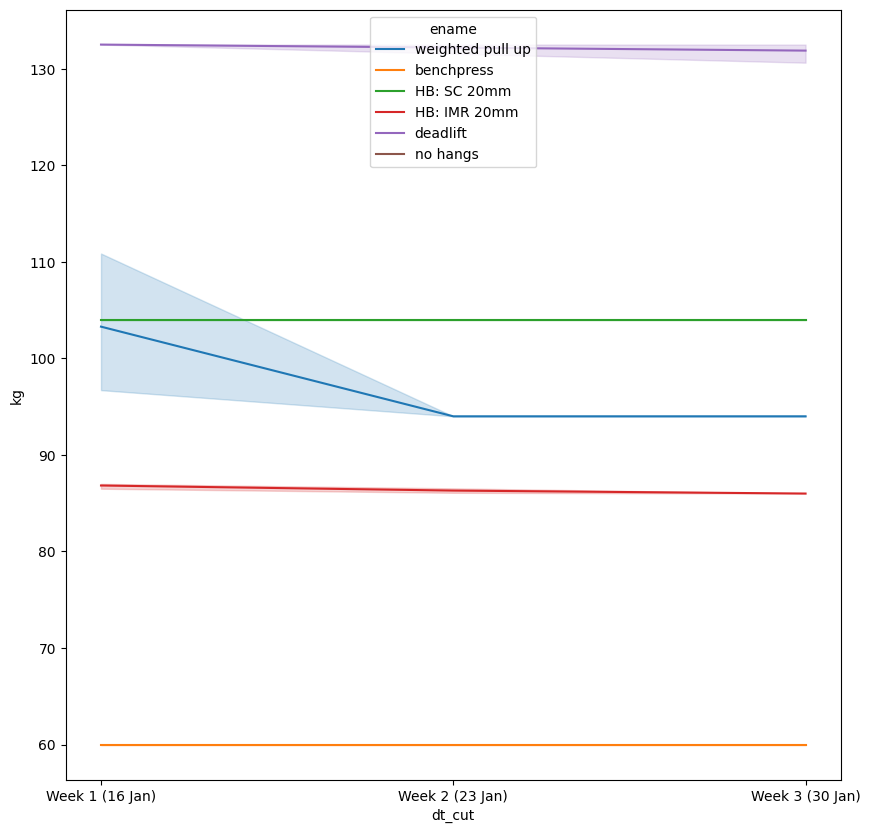

In [44]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.lineplot(data=df2, x='dt_cut', y='kg', hue='ename')

In [45]:
# Filter out exercises outside block range
df2 = df2.dropna(subset="dt_cut")

In [46]:
grp = df2.groupby(['dt_cut', 'ename']).aggregate(
    volume_reps = ('ereps', sum),
    volume_time = ('duration', sum),
    max_kg = ('kg', max),
    accum_load = ('rep_load', sum),
    sessions = ('date', 'nunique')    
).fillna(0)
grp

/tmp/ipykernel_1240593/3603228834.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df2.groupby(['dt_cut', 'ename']).aggregate(
/tmp/ipykernel_1240593/3603228834.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  grp = df2.groupby(['dt_cut', 'ename']).aggregate(
/tmp/ipykernel_1240593/3603228834.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  grp = df2.groupby(['dt_cut', 'ename']).aggregate(
/tmp/ipykernel_1240593/3603228834.py:1: FutureWa

volume_reps  volume_time  max_kg  \
dt_cut          ename                                                
Week 1 (16 Jan) HB: IMR 20mm                6       60.000    87.0   
                HB: SC 20mm                 6       60.000   104.0   
                benchpress                 15       15.000    60.0   
                deadlift                    9       63.937   132.5   
                weighted pull up           23       20.000   117.0   
Week 2 (23 Jan) HB: IMR 20mm               13      124.575    87.0   
                HB: SC 20mm                14      130.000   104.0   
                benchpress                 20      118.118    60.0   
                deadlift                    0        0.000     0.0   
                weighted pull up           20       81.350    94.0   
Week 3 (30 Jan) HB: IMR 20mm                7       50.000    86.0   
                HB: SC 20mm                 7       50.000   104.0   
                benchpress                 70      357.232    60.0   
                deadlift                   12      120.000   132.5   
                weighted pull up           70      277.691    94.0   
Week 4 (06 Feb) HB: IMR 20mm                0        0.000     0.0   
                HB: SC 20mm                 0        0.000     0.0   
                benchpress                  0        0.000     0.0   
                deadlift                    0        0.000     0.0   
                weighted pull up            0        0.000     0.0   

                                  accum_load  sessions  
dt_cut          ename                                   
Week 1 (16 Jan) HB: IMR 20mm         2084.00         2  
                HB: SC 20mm          2496.00         2  
                benchpress            900.00         1  
                deadlift             1192.50         1  
                weighted pull up     2251.00         1  
Week 2 (23 Jan) HB: IMR 20mm         4299.21         3  
                HB: SC 20mm          5408.00         3  
                benchpress           1200.00         1  
                deadlift                0.00         0  
                weighted pull up     1880.00         1  
Week 3 (30 Jan) HB: IMR 20mm         1720.00         1  
                HB: SC 20mm          2080.00         1  
                benchpress           4200.00         3  
                deadlift             1582.50         1  
                weighted pull up     6580.00         3  
Week 4 (06 Feb) HB: IMR 20mm            0.00         0  
                HB: SC 20mm             0.00         0  
                benchpress              0.00         0  
                deadlift                0.00         0  
                weighted pull up        0.00         0

In [74]:
grp.loc[("Week 5 (18 Dec)", "no hangs"), :]

volume_reps      33.0
volume_time     320.0
max_kg           62.0
accum_load     2046.0
sessions          4.0
Name: (Week 5 (18 Dec), no hangs), dtype: float64

In [97]:
grp.unstack(level=-1)

volume_reps                                           \
ename           HB: IMR 20mm HB: SC 20mm benchpress deadlift no hangs   
dt_cut                                                                  
Week 1 (20 Nov)           70          55         25       21        0   
Week 2 (27 Nov)           54          60         17       20        0   
Week 3 (04 Dec)           30          30          9        0        0   
Week 4 (11 Dec)            0           0         11        9        8   
Week 5 (18 Dec)            3           3          0       12       33   
Week 6 (25 Dec)            0           0          0        0        0   

                                  volume_time                                  \
ename           weighted pull up HB: IMR 20mm HB: SC 20mm benchpress deadlift   
dt_cut                                                                          
Week 1 (20 Nov)               15        210.0       180.0      240.0  240.000   
Week 2 (27 Nov)                0        180.0       180.0      120.0  180.000   
Week 3 (04 Dec)                0         90.0        90.0       90.0    0.000   
Week 4 (11 Dec)                9          0.0         0.0        0.0   83.703   
Week 5 (18 Dec)                0         30.0        30.0        0.0   85.359   
Week 6 (25 Dec)                0          0.0         0.0        0.0    0.000   

                 ... accum_load                                     \
ename            ... benchpress deadlift no hangs weighted pull up   
dt_cut           ...                                                 
Week 1 (20 Nov)  ...     1500.0   2765.0      0.0           1597.5   
Week 2 (27 Nov)  ...     1020.0   2600.0      0.0              0.0   
Week 3 (04 Dec)  ...      585.0      0.0      0.0              0.0   
Week 4 (11 Dec)  ...      715.0   1215.0    496.0            999.0   
Week 5 (18 Dec)  ...        0.0   1620.0   2046.0              0.0   
Week 6 (25 Dec)  ...        0.0      0.0      0.0              0.0   

                    sessions                                           \
ename           HB: IMR 20mm HB: SC 20mm benchpress deadlift no hangs   
dt_cut                                                                  
Week 1 (20 Nov)            2           2          2        2        0   
Week 2 (27 Nov)            2           2          1        2        0   
Week 3 (04 Dec)            1           1          1        0        0   
Week 4 (11 Dec)            0           0          1        1        1   
Week 5 (18 Dec)            1           1          0        1        4   
Week 6 (25 Dec)            0           0          0        0        0   

                                  
ename           weighted pull up  
dt_cut                            
Week 1 (20 Nov)                1  
Week 2 (27 Nov)                0  
Week 3 (04 Dec)                0  
Week 4 (11 Dec)                1  
Week 5 (18 Dec)                0  
Week 6 (25 Dec)                0  

[6 rows x 30 columns]

array([[<Axes: title={'center': '(sessions, HB: IMR 20mm)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, HB: SC 20mm)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, benchpress)'}, xlabel='dt_cut'>],
       [<Axes: title={'center': '(sessions, deadlift)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, no hangs)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, weighted pull up)'}, xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes

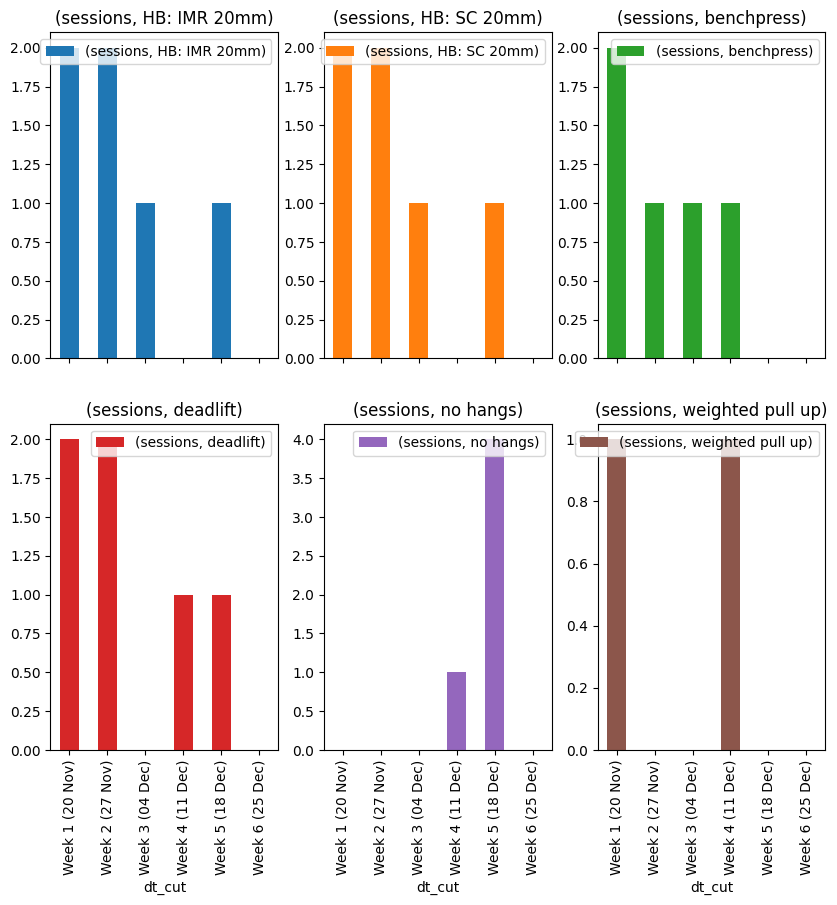

In [101]:
# grp.unstack(level=-1)[['sessions']].plot(rot=90, subplots=True, marker='x', linestyle="", figsize=(10,50), layout=(10,3))
grp.unstack(level=-1)[['sessions']].plot(kind='bar', rot=90, subplots=True, figsize=(10,50), layout=(10,3))

In [109]:
# Plots

# Sessions per week
grp.unstack(level=-1)['sessions'].T.plot(kind='pie', subplots=True, figsize=(50,50))

/home/matt/venvs/moonplot/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3193: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 5000x5000 with 6 Axes>